<a href="https://colab.research.google.com/github/GWANGHYUNYU/Audio/blob/main/train_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 87

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
((x_train, y_train), (x_test, y_test)) = fashion_mnist.load_data()

## 전처리

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [ ]:
h, w = x_train.shape[1], x_train.shape[2]
IMG_SIZE = h, w
print(IMG_SIZE)

(28, 28)


In [ ]:
print(x_train.dtype)
print(y_train.dtype)
print(x_test.dtype)
print(y_test.dtype)

uint8
uint8
uint8
uint8


In [ ]:
x_train = x_train.astype(np.float64)
x_test = x_test.astype(np.float64)

In [ ]:
print(x_train.dtype)
print(y_train.dtype)
print(x_test.dtype)
print(y_test.dtype)

float64
uint8
float64
uint8


In [ ]:
print(x_train.max(), x_train.min())
print(x_test.max(), x_test.min())

255.0 0.0
255.0 0.0


In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
print(x_train.max(), x_train.min())
print(x_test.max(), x_test.min())

1.0 0.0
1.0 0.0


In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000, 10)
(10000, 28, 28)
(10000, 10)


## 시각화

In [ ]:
fashion_mnist_class = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
def idx2label(idx):
    return fashion_mnist_class[idx]

In [ ]:
idx2label(5)

'Sandal'

In [ ]:
def filter(label, count=5):
    sample_labels = x_train[np.argwhere(y_train == label)[:count, ..., 0]].transpose((1,0,2)).reshape((28,-1))
    plt.imshow(sample_labels)
    plt.show()

In [ ]:
def rand_filter(label, count=5):
    range = len(np.argwhere(y_train == 0))
    idx = np.random.randint(0,range-5)
    print(idx, idx+count)
    sample_labels = x_train[np.argwhere(y_train == label)[idx:idx+count, ..., 0]].transpose((1,0,2)).reshape((28,-1))
    plt.imshow(sample_labels)
    plt.show()

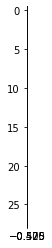

In [ ]:
filter(9)

5413 5418


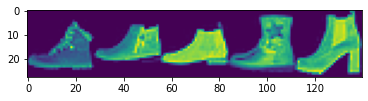

In [ ]:
rand_filter(9)

## 모델 설계

In [ ]:
# Create the base model from the pre-trained model Resnet-50

IMG_SHAPE = (32, 32) + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

# ResNet50 불러오기에서 include_top=을 True가 아닌 False로 둠으로써 사전학습된 모델의 최상층 분류기를 사용하지 않겠다고 설정

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# base_model.trainable = False를 통해 사전학습된 resnet이 기존에 기억하던 weights를 손상주지 않기 위해 동결

base_model.trainable = False

In [ ]:
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Input, Dense, Flatten, Concatenate

inputs = Input((28, 28, 1))
resized_x = tf.keras.layers.experimental.preprocessing.Resizing(32, 32)(inputs)
first_conv_layer = Conv2D(3, 1, padding='same', activation=None)(resized_x)

x = base_model(first_conv_layer, training = False)
x = Flatten()(x)
outputs = Dense(10, activation = 'softmax')(x)

model = tf.keras.Model(inputs, outputs, name="fashion_mnist_resnet50_model")

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:
model.summary()

Model: "fashion_mnist_resnet50_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 3)         6         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,608,208
Trainable par

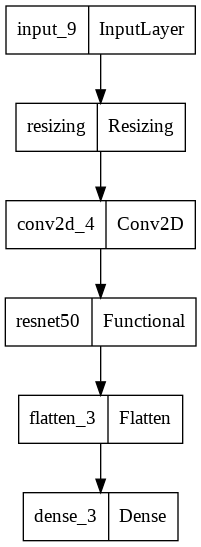

In [ ]:
keras.utils.plot_model(model, "fashion_mnist_resnet50_model.png")

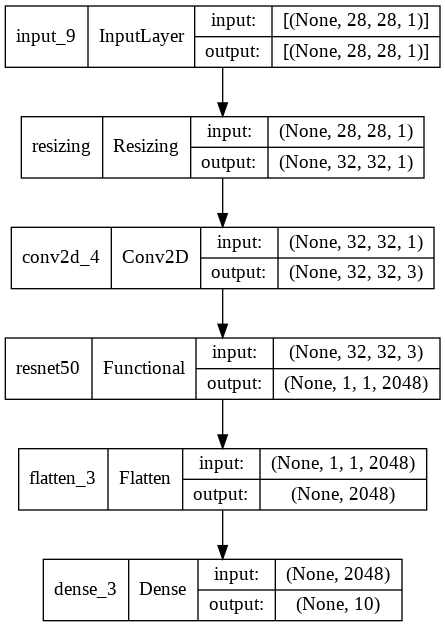

In [ ]:
keras.utils.plot_model(model, "fashion_mnist_resnet50_model_with_shape_info.png", show_shapes=True)

In [ ]:
model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001), 
              metrics=['accuracy'])

In [ ]:
# early stopping 설정
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# 모델 fitting
hist = model.fit(x_train, y_train,
                 validation_data = (x_test, y_test),
                 epochs = 20,
                 batch_size = 256,
                 verbose = 1,
                 callbacks=[early])

Epoch 1/20
235/235 [==============================] - 3368s 14s/step - loss: 0.5950 - accuracy: 0.7850 - val_loss: 0.6151 - val_accuracy: 0.7780
Epoch 2/20
 48/235 [=====>........................] - ETA: 43:24 - loss: 0.5863 - accuracy: 0.7930

## 모델 학습 기록

In [ ]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

## 모델 테스트

In [ ]:
res = model.predict(x_test[3])
res.shape

In [ ]:
plt.bar(np.arange(0, 10), y_test[3], color="black")

In [ ]:
plt.bar(np.arange(0, 10), res[0] > 0.3, color="red")

## 모델 저장 및 로드

In [ ]:
# 모델을 저장하는 코드
model.save('./fashion_mnist_resnet50_model.h5')

In [ ]:
# 모델을 로드하는 코드
load_model = tf.keras.models.load_model('./fashion_mnist_resnet50_model.h5')

In [ ]:
# 로드한 모델로 test 데이터 평가
loss, acc = load_model.evaluate(x_test, y_test)
print(loss, acc)

In [ ]:
# 모델을 내 컴퓨터에 저장
from google.colab import files
files.download('./fashion_mnist_resnet50_model.h5')